# Import libraries

In [ ]:
# mamba install gpy
# mamba install richdem

In [ ]:
pip install tensorflow

In [ ]:
pip install parameter-sherpa

In [ ]:
pip install shap

In [2]:
import numpy as np
import numpy.ma as ma
import xarray as xr
import pandas as pd
import scipy.io as sio
from scipy import stats
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import gaussian_kde
import tensorflow
import io
import os
from PIL import Image
import seaborn as sns
import richdem as rd

import tensorflow as tf
import tensorflow.math
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Input
from sherpa import multiprocessing

import shap

plt.rcParams['figure.figsize'] = (12,12)

# Load MAR output

#### Load local MAR output for 2020 on 6.5km

In [ ]:
ds2008 = xr.open_dataset('/home/jovyan/MARv3.12-6_5km-daily-ERA5-2008.nc')
# ds2020 = xr.open_dataset('/home/jovyan/MARv3.12-6_5km-daily-ERA5-2020.nc')

In [165]:
# LAT = ds2020.LAT.values
# LON = ds2020.LON.values
# AL2_2020 = ds2020.AL2.values[jun1_leap:aug31_leap+1,0,:n_lat,:n_lon] * np.where(y_test[:,:n_lat,:n_lon] > -8, 1, np.nan)

# np.save('./LAT.npy', LAT)
# np.save('./LON.npy', LON)
# np.save('./AL2_2020.npy', AL2_2020)

In [2]:
LAT = np.load('./LAT.npy')
LON = np.load('./LON.npy')
AL2_2020 = np.load('./AL2_2020.npy')

#### Load bare ice variable (from Antwerpen et al., 2022). This variables gives 1's for bare ice and NaNs for non-bare ice (snow, land, or ocean) daily for June, July, and August in 2000-2021

In [3]:
ds_bie = sio.loadmat('/home/jovyan/sboth_6km.mat')

#### Flip matrix right-side up and change dimension order

In [4]:
bareice = np.flipud(ds_bie['sboth_6km'])
bareice = np.transpose(bareice, (3, 0, 1, 2))

In [5]:
# bareice_sub = bareice[:,:,:,9:21]
bareice_sub = bareice[:,:,:,6:21]

In [6]:
numberdaystot =  1380

bareice0920 = np.zeros((numberdaystot,415,230))

for i in range(15):
    bareice0920[i*92:i*92+92,:,:] = bareice_sub[:,:,:,i]

#### Load variables from MAR for June, July, and August in 2020 and place them in new variable 'x'. Variables loaded: surface temperature (ST2), liquid water content (WA1), shortwave radiation up/down (SWU/SWD), longwave radiation up/down (LWU/LWD), sensible heat flux (SHF), latent heat flux (LHF), x-wind speed component (UU), y-wind speed component (VV), surface pressure (SP), sublimation from snow/soil (SU), snowfall (SF), rainfall (RF), cloud cover up/middle/down (CU/CM/CD), cloud optical depth (COD), density (RO1), surface height (SH), soil type (SOL)

In [7]:
jun1 = 151
aug31 = 242
numberdays = aug31-jun1+1

jun1_leap = jun1 + 1
aug31_leap = aug31 + 1

numberyears = 12

n_feature = 19
n_lat = int(415/2)
n_lon = 100

In [ ]:
# SH_vals = rd.rdarray(ds2020.SH.values, no_data=-9999)

# slope = rd.TerrainAttribute(SH_vals, attrib='slope_riserun')
# aspect = rd.TerrainAttribute(SH_vals, attrib='aspect')

In [10]:
jun1 = 151
aug31 = 242
numberdays = aug31-jun1+1

jun1_leap = jun1 + 1
aug31_leap = aug31 + 1

numberyears = 12

n_feature = 19
n_lat = int(415/2)
n_lon = 100

x = np.zeros((numberyears, numberdays, n_lat, n_lon, n_feature))

x[0,:,:,:,0] = ds2009.ST2.values[jun1:aug31+1,0,:n_lat,:n_lon]
x[0,:,:,:,1] = ds2009.SWU.values[jun1:aug31+1,:n_lat,:n_lon]
x[0,:,:,:,2] = ds2009.SWD.values[jun1:aug31+1,:n_lat,:n_lon]
x[0,:,:,:,3] = ds2009.LWU.values[jun1:aug31+1,:n_lat,:n_lon]
x[0,:,:,:,4] = ds2009.LWD.values[jun1:aug31+1,:n_lat,:n_lon]
x[0,:,:,:,5] = ds2009.SHF.values[jun1:aug31+1,:n_lat,:n_lon]
x[0,:,:,:,6] = ds2009.LHF.values[jun1:aug31+1,:n_lat,:n_lon]
x[0,:,:,:,7] = ds2009.SP.values[jun1:aug31+1,:n_lat,:n_lon]
x[0,:,:,:,8] = np.mean(ds2009.RO1.values[jun1:aug31+1,0:9,:n_lat,:n_lon], 1) # average of top 1m
x[0,:,:,:,9] = ds2009.AL2.values[jun1:aug31+1,0,:n_lat,:n_lon]
x[0,:,:,:,10] = ds2009.UU.values[jun1:aug31+1,0,:n_lat,:n_lon]
x[0,:,:,:,11] = ds2009.VV.values[jun1:aug31+1,0,:n_lat,:n_lon]
x[0,:,:,:,12] = ds2009.SU.values[jun1:aug31+1,0,:n_lat,:n_lon]
x[0,:,:,:,13] = np.mean(ds2009.WA1.values[jun1:aug31+1,0:9,:n_lat,:n_lon], 1) # average of top 1m
x[0,:,:,:,14] = ds2009.SF.values[jun1:aug31+1,:n_lat,:n_lon]
# repeat the same data for each day for surface height (SH) and soil type (SOL) since they do not vary temporally.
for i in range(aug31-jun1+1):
    x[0,i,:,:,15] = ds2020.SH.values[:n_lat,:n_lon]
    x[0,i,:,:,16] = ds2020.SOL.values[:n_lat,:n_lon]
    x[0,i,:,:,17] = slope[:n_lat,:n_lon]
    x[0,i,:,:,18] = aspect[:n_lat,:n_lon]

x[1,:,:,:,0] = ds2010.ST2.values[jun1:aug31+1,0,:n_lat,:n_lon]
x[1,:,:,:,1] = ds2010.SWU.values[jun1:aug31+1,:n_lat,:n_lon]
x[1,:,:,:,2] = ds2010.SWD.values[jun1:aug31+1,:n_lat,:n_lon]
x[1,:,:,:,3] = ds2010.LWU.values[jun1:aug31+1,:n_lat,:n_lon]
x[1,:,:,:,4] = ds2010.LWD.values[jun1:aug31+1,:n_lat,:n_lon]
x[1,:,:,:,5] = ds2010.SHF.values[jun1:aug31+1,:n_lat,:n_lon]
x[1,:,:,:,6] = ds2010.LHF.values[jun1:aug31+1,:n_lat,:n_lon]
x[1,:,:,:,7] = ds2010.SP.values[jun1:aug31+1,:n_lat,:n_lon]
x[1,:,:,:,8] = np.mean(ds2010.RO1.values[jun1:aug31+1,0:9,:n_lat,:n_lon], 1) # average of top 1m
x[1,:,:,:,9] = ds2010.AL2.values[jun1:aug31+1,0,:n_lat,:n_lon]
x[1,:,:,:,10] = ds2010.UU.values[jun1:aug31+1,0,:n_lat,:n_lon]
x[1,:,:,:,11] = ds2010.VV.values[jun1:aug31+1,0,:n_lat,:n_lon]
x[1,:,:,:,12] = ds2010.SU.values[jun1:aug31+1,0,:n_lat,:n_lon]
x[1,:,:,:,13] = np.mean(ds2010.WA1.values[jun1:aug31+1,0:9,:n_lat,:n_lon], 1) # average of top 1m
x[1,:,:,:,14] = ds2010.SF.values[jun1:aug31+1,:n_lat,:n_lon]
# repeat the same data for each day for surface height (SH) and soil type (SOL) since they do not vary temporally.
for i in range(aug31-jun1+1):
    x[1,i,:,:,15] = ds2020.SH.values[:n_lat,:n_lon]
    x[1,i,:,:,16] = ds2020.SOL.values[:n_lat,:n_lon]
    x[1,i,:,:,17] = slope[:n_lat,:n_lon]
    x[1,i,:,:,18] = aspect[:n_lat,:n_lon]

x[2,:,:,:,0] = ds2011.ST2.values[jun1:aug31+1,0,:n_lat,:n_lon]
x[2,:,:,:,1] = ds2011.SWU.values[jun1:aug31+1,:n_lat,:n_lon]
x[2,:,:,:,2] = ds2011.SWD.values[jun1:aug31+1,:n_lat,:n_lon]
x[2,:,:,:,3] = ds2011.LWU.values[jun1:aug31+1,:n_lat,:n_lon]
x[2,:,:,:,4] = ds2011.LWD.values[jun1:aug31+1,:n_lat,:n_lon]
x[2,:,:,:,5] = ds2011.SHF.values[jun1:aug31+1,:n_lat,:n_lon]
x[2,:,:,:,6] = ds2011.LHF.values[jun1:aug31+1,:n_lat,:n_lon]
x[2,:,:,:,7] = ds2011.SP.values[jun1:aug31+1,:n_lat,:n_lon]
x[2,:,:,:,8] = np.mean(ds2011.RO1.values[jun1:aug31+1,0:9,:n_lat,:n_lon], 1) # average of top 1m
x[2,:,:,:,9] = ds2011.AL2.values[jun1:aug31+1,0,:n_lat,:n_lon]
x[2,:,:,:,10] = ds2011.UU.values[jun1:aug31+1,0,:n_lat,:n_lon]
x[2,:,:,:,11] = ds2011.VV.values[jun1:aug31+1,0,:n_lat,:n_lon]
x[2,:,:,:,12] = ds2011.SU.values[jun1:aug31+1,0,:n_lat,:n_lon]
x[2,:,:,:,13] = np.mean(ds2011.WA1.values[jun1:aug31+1,0:9,:n_lat,:n_lon], 1) # average of top 1m
x[2,:,:,:,14] = ds2011.SF.values[jun1:aug31+1,:n_lat,:n_lon]
# repeat the same data for each day for surface height (SH) and soil type (SOL) since they do not vary temporally.
for i in range(aug31-jun1+1):
    x[2,i,:,:,15] = ds2020.SH.values[:n_lat,:n_lon]
    x[2,i,:,:,16] = ds2020.SOL.values[:n_lat,:n_lon]
    x[2,i,:,:,17] = slope[:n_lat,:n_lon]
    x[2,i,:,:,18] = aspect[:n_lat,:n_lon]

x[3,:,:,:,0] = ds2012.ST2.values[jun1_leap:aug31_leap+1,0,:n_lat,:n_lon]
x[3,:,:,:,1] = ds2012.SWU.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
x[3,:,:,:,2] = ds2012.SWD.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
x[3,:,:,:,3] = ds2012.LWU.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
x[3,:,:,:,4] = ds2012.LWD.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
x[3,:,:,:,5] = ds2012.SHF.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
x[3,:,:,:,6] = ds2012.LHF.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
x[3,:,:,:,7] = ds2012.SP.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
x[3,:,:,:,8] = np.mean(ds2012.RO1.values[jun1_leap:aug31_leap+1,0:9,:n_lat,:n_lon], 1) # average of top 1m
x[3,:,:,:,9] = ds2012.AL2.values[jun1_leap:aug31_leap+1,0,:n_lat,:n_lon]
x[3,:,:,:,10] = ds2012.UU.values[jun1_leap:aug31_leap+1,0,:n_lat,:n_lon]
x[3,:,:,:,11] = ds2012.VV.values[jun1_leap:aug31_leap+1,0,:n_lat,:n_lon]
x[3,:,:,:,12] = ds2012.SU.values[jun1_leap:aug31_leap+1,0,:n_lat,:n_lon]
x[3,:,:,:,13] = np.mean(ds2012.WA1.values[jun1_leap:aug31_leap+1,0:9,:n_lat,:n_lon], 1) # average of top 1m
x[3,:,:,:,14] = ds2012.SF.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
# repeat the same data for each day for surface height (SH) and soil type (SOL) since they do not vary temporally.
for i in range(aug31_leap-jun1_leap+1):
    x[3,i,:,:,15] = ds2020.SH.values[:n_lat,:n_lon]
    x[3,i,:,:,16] = ds2020.SOL.values[:n_lat,:n_lon]
    x[3,i,:,:,17] = slope[:n_lat,:n_lon]
    x[3,i,:,:,18] = aspect[:n_lat,:n_lon]

x[4,:,:,:,0] = ds2013.ST2.values[jun1:aug31+1,0,:n_lat,:n_lon]
x[4,:,:,:,1] = ds2013.SWU.values[jun1:aug31+1,:n_lat,:n_lon]
x[4,:,:,:,2] = ds2013.SWD.values[jun1:aug31+1,:n_lat,:n_lon]
x[4,:,:,:,3] = ds2013.LWU.values[jun1:aug31+1,:n_lat,:n_lon]
x[4,:,:,:,4] = ds2013.LWD.values[jun1:aug31+1,:n_lat,:n_lon]
x[4,:,:,:,5] = ds2013.SHF.values[jun1:aug31+1,:n_lat,:n_lon]
x[4,:,:,:,6] = ds2013.LHF.values[jun1:aug31+1,:n_lat,:n_lon]
x[4,:,:,:,7] = ds2013.SP.values[jun1:aug31+1,:n_lat,:n_lon]
x[4,:,:,:,8] = np.mean(ds2013.RO1.values[jun1:aug31+1,0:9,:n_lat,:n_lon], 1) # average of top 1m
x[4,:,:,:,9] = ds2013.AL2.values[jun1:aug31+1,0,:n_lat,:n_lon]
x[4,:,:,:,10] = ds2013.UU.values[jun1:aug31+1,0,:n_lat,:n_lon]
x[4,:,:,:,11] = ds2013.VV.values[jun1:aug31+1,0,:n_lat,:n_lon]
x[4,:,:,:,12] = ds2013.SU.values[jun1:aug31+1,0,:n_lat,:n_lon]
x[4,:,:,:,13] = np.mean(ds2013.WA1.values[jun1:aug31+1,0:9,:n_lat,:n_lon], 1) # average of top 1m
x[4,:,:,:,14] = ds2013.SF.values[jun1:aug31+1,:n_lat,:n_lon]
# repeat the same data for each day for surface height (SH) and soil type (SOL) since they do not vary temporally.
for i in range(aug31-jun1+1):
    x[4,i,:,:,15] = ds2020.SH.values[:n_lat,:n_lon]
    x[4,i,:,:,16] = ds2020.SOL.values[:n_lat,:n_lon]
    x[4,i,:,:,17] = slope[:n_lat,:n_lon]
    x[4,i,:,:,18] = aspect[:n_lat,:n_lon]

x[5,:,:,:,0] = ds2014.ST2.values[jun1:aug31+1,0,:n_lat,:n_lon]
x[5,:,:,:,1] = ds2014.SWU.values[jun1:aug31+1,:n_lat,:n_lon]
x[5,:,:,:,2] = ds2014.SWD.values[jun1:aug31+1,:n_lat,:n_lon]
x[5,:,:,:,3] = ds2014.LWU.values[jun1:aug31+1,:n_lat,:n_lon]
x[5,:,:,:,4] = ds2014.LWD.values[jun1:aug31+1,:n_lat,:n_lon]
x[5,:,:,:,5] = ds2014.SHF.values[jun1:aug31+1,:n_lat,:n_lon]
x[5,:,:,:,6] = ds2014.LHF.values[jun1:aug31+1,:n_lat,:n_lon]
x[5,:,:,:,7] = ds2014.SP.values[jun1:aug31+1,:n_lat,:n_lon]
x[5,:,:,:,8] = np.mean(ds2014.RO1.values[jun1:aug31+1,0:9,:n_lat,:n_lon], 1) # average of top 1m
x[5,:,:,:,9] = ds2014.AL2.values[jun1:aug31+1,0,:n_lat,:n_lon]
x[5,:,:,:,10] = ds2014.UU.values[jun1:aug31+1,0,:n_lat,:n_lon]
x[5,:,:,:,11] = ds2014.VV.values[jun1:aug31+1,0,:n_lat,:n_lon]
x[5,:,:,:,12] = ds2014.SU.values[jun1:aug31+1,0,:n_lat,:n_lon]
x[5,:,:,:,13] = np.mean(ds2014.WA1.values[jun1:aug31+1,0:9,:n_lat,:n_lon], 1) # average of top 1m
x[5,:,:,:,14] = ds2014.SF.values[jun1:aug31+1,:n_lat,:n_lon]
# repeat the same data for each day for surface height (SH) and soil type (SOL) since they do not vary temporally.
for i in range(aug31-jun1+1):
    x[5,i,:,:,15] = ds2020.SH.values[:n_lat,:n_lon]
    x[5,i,:,:,16] = ds2020.SOL.values[:n_lat,:n_lon]
    x[5,i,:,:,17] = slope[:n_lat,:n_lon]
    x[5,i,:,:,18] = aspect[:n_lat,:n_lon]

x[6,:,:,:,0] = ds2015.ST2.values[jun1:aug31+1,0,:n_lat,:n_lon]
x[6,:,:,:,1] = ds2015.SWU.values[jun1:aug31+1,:n_lat,:n_lon]
x[6,:,:,:,2] = ds2015.SWD.values[jun1:aug31+1,:n_lat,:n_lon]
x[6,:,:,:,3] = ds2015.LWU.values[jun1:aug31+1,:n_lat,:n_lon]
x[6,:,:,:,4] = ds2015.LWD.values[jun1:aug31+1,:n_lat,:n_lon]
x[6,:,:,:,5] = ds2015.SHF.values[jun1:aug31+1,:n_lat,:n_lon]
x[6,:,:,:,6] = ds2015.LHF.values[jun1:aug31+1,:n_lat,:n_lon]
x[6,:,:,:,7] = ds2015.SP.values[jun1:aug31+1,:n_lat,:n_lon]
x[6,:,:,:,8] = np.mean(ds2015.RO1.values[jun1:aug31+1,0:9,:n_lat,:n_lon], 1) # average of top 1m
x[6,:,:,:,9] = ds2015.AL2.values[jun1:aug31+1,0,:n_lat,:n_lon]
x[6,:,:,:,10] = ds2015.UU.values[jun1:aug31+1,0,:n_lat,:n_lon]
x[6,:,:,:,11] = ds2015.VV.values[jun1:aug31+1,0,:n_lat,:n_lon]
x[6,:,:,:,12] = ds2015.SU.values[jun1:aug31+1,0,:n_lat,:n_lon]
x[6,:,:,:,13] = np.mean(ds2015.WA1.values[jun1:aug31+1,0:9,:n_lat,:n_lon], 1) # average of top 1m
x[6,:,:,:,14] = ds2015.SF.values[jun1:aug31+1,:n_lat,:n_lon]
# repeat the same data for each day for surface height (SH) and soil type (SOL) since they do not vary temporally.
for i in range(aug31-jun1+1):
    x[6,i,:,:,15] = ds2020.SH.values[:n_lat,:n_lon]
    x[6,i,:,:,16] = ds2020.SOL.values[:n_lat,:n_lon]
    x[6,i,:,:,17] = slope[:n_lat,:n_lon]
    x[6,i,:,:,18] = aspect[:n_lat,:n_lon]

x[7,:,:,:,0] = ds2016.ST2.values[jun1_leap:aug31_leap+1,0,:n_lat,:n_lon]
x[7,:,:,:,1] = ds2016.SWU.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
x[7,:,:,:,2] = ds2016.SWD.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
x[7,:,:,:,3] = ds2016.LWU.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
x[7,:,:,:,4] = ds2016.LWD.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
x[7,:,:,:,5] = ds2016.SHF.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
x[7,:,:,:,6] = ds2016.LHF.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
x[7,:,:,:,7] = ds2016.SP.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
x[7,:,:,:,8] = np.mean(ds2016.RO1.values[jun1_leap:aug31_leap+1,0:9,:n_lat,:n_lon], 1) # average of top 1m
x[7,:,:,:,9] = ds2016.AL2.values[jun1_leap:aug31_leap+1,0,:n_lat,:n_lon]
x[7,:,:,:,10] = ds2016.UU.values[jun1_leap:aug31_leap+1,0,:n_lat,:n_lon]
x[7,:,:,:,11] = ds2016.VV.values[jun1_leap:aug31_leap+1,0,:n_lat,:n_lon]
x[7,:,:,:,12] = ds2016.SU.values[jun1_leap:aug31_leap+1,0,:n_lat,:n_lon]
x[7,:,:,:,13] = np.mean(ds2016.WA1.values[jun1_leap:aug31_leap+1,0:9,:n_lat,:n_lon], 1) # average of top 1m
x[7,:,:,:,14] = ds2016.SF.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
# repeat the same data for each day for surface height (SH) and soil type (SOL) since they do not vary temporally.
for i in range(aug31_leap-jun1_leap+1):
    x[7,i,:,:,15] = ds2020.SH.values[:n_lat,:n_lon]
    x[7,i,:,:,16] = ds2020.SOL.values[:n_lat,:n_lon]
    x[7,i,:,:,17] = slope[:n_lat,:n_lon]
    x[7,i,:,:,18] = aspect[:n_lat,:n_lon]

x[8,:,:,:,0] = ds2017.ST2.values[jun1:aug31+1,0,:n_lat,:n_lon]
x[8,:,:,:,1] = ds2017.SWU.values[jun1:aug31+1,:n_lat,:n_lon]
x[8,:,:,:,2] = ds2017.SWD.values[jun1:aug31+1,:n_lat,:n_lon]
x[8,:,:,:,3] = ds2017.LWU.values[jun1:aug31+1,:n_lat,:n_lon]
x[8,:,:,:,4] = ds2017.LWD.values[jun1:aug31+1,:n_lat,:n_lon]
x[8,:,:,:,5] = ds2017.SHF.values[jun1:aug31+1,:n_lat,:n_lon]
x[8,:,:,:,6] = ds2017.LHF.values[jun1:aug31+1,:n_lat,:n_lon]
x[8,:,:,:,7] = ds2017.SP.values[jun1:aug31+1,:n_lat,:n_lon]
x[8,:,:,:,8] = np.mean(ds2017.RO1.values[jun1:aug31+1,0:9,:n_lat,:n_lon], 1) # average of top 1m
x[8,:,:,:,9] = ds2017.AL2.values[jun1:aug31+1,0,:n_lat,:n_lon]
x[8,:,:,:,10] = ds2017.UU.values[jun1:aug31+1,0,:n_lat,:n_lon]
x[8,:,:,:,11] = ds2017.VV.values[jun1:aug31+1,0,:n_lat,:n_lon]
x[8,:,:,:,12] = ds2017.SU.values[jun1:aug31+1,0,:n_lat,:n_lon]
x[8,:,:,:,13] = np.mean(ds2017.WA1.values[jun1:aug31+1,0:9,:n_lat,:n_lon], 1) # average of top 1m
x[8,:,:,:,14] = ds2017.SF.values[jun1:aug31+1,:n_lat,:n_lon]
# repeat the same data for each day for surface height (SH) and soil type (SOL) since they do not vary temporally.
for i in range(aug31-jun1+1):
    x[8,i,:,:,15] = ds2020.SH.values[:n_lat,:n_lon]
    x[8,i,:,:,16] = ds2020.SOL.values[:n_lat,:n_lon]
    x[8,i,:,:,17] = slope[:n_lat,:n_lon]
    x[8,i,:,:,18] = aspect[:n_lat,:n_lon]

x[9,:,:,:,0] = ds2018.ST2.values[jun1:aug31+1,0,:n_lat,:n_lon]
x[9,:,:,:,1] = ds2018.SWU.values[jun1:aug31+1,:n_lat,:n_lon]
x[9,:,:,:,2] = ds2018.SWD.values[jun1:aug31+1,:n_lat,:n_lon]
x[9,:,:,:,3] = ds2018.LWU.values[jun1:aug31+1,:n_lat,:n_lon]
x[9,:,:,:,4] = ds2018.LWD.values[jun1:aug31+1,:n_lat,:n_lon]
x[9,:,:,:,5] = ds2018.SHF.values[jun1:aug31+1,:n_lat,:n_lon]
x[9,:,:,:,6] = ds2018.LHF.values[jun1:aug31+1,:n_lat,:n_lon]
x[9,:,:,:,7] = ds2018.SP.values[jun1:aug31+1,:n_lat,:n_lon]
x[9,:,:,:,8] = np.mean(ds2018.RO1.values[jun1:aug31+1,0:9,:n_lat,:n_lon], 1) # average of top 1m
x[9,:,:,:,9] = ds2018.AL2.values[jun1:aug31+1,0,:n_lat,:n_lon]
x[9,:,:,:,10] = ds2018.UU.values[jun1:aug31+1,0,:n_lat,:n_lon]
x[9,:,:,:,11] = ds2018.VV.values[jun1:aug31+1,0,:n_lat,:n_lon]
x[9,:,:,:,12] = ds2018.SU.values[jun1:aug31+1,0,:n_lat,:n_lon]
x[9,:,:,:,13] = np.mean(ds2018.WA1.values[jun1:aug31+1,0:9,:n_lat,:n_lon], 1) # average of top 1m
x[9,:,:,:,14] = ds2018.SF.values[jun1:aug31+1,:n_lat,:n_lon]
# repeat the same data for each day for surface height (SH) and soil type (SOL) since they do not vary temporally.
for i in range(aug31-jun1+1):
    x[9,i,:,:,15] = ds2020.SH.values[:n_lat,:n_lon]
    x[9,i,:,:,16] = ds2020.SOL.values[:n_lat,:n_lon]
    x[9,i,:,:,17] = slope[:n_lat,:n_lon]
    x[9,i,:,:,18] = aspect[:n_lat,:n_lon]

x[10,:,:,:,0] = ds2019.ST2.values[jun1:aug31+1,0,:n_lat,:n_lon]
x[10,:,:,:,1] = ds2019.SWU.values[jun1:aug31+1,:n_lat,:n_lon]
x[10,:,:,:,2] = ds2019.SWD.values[jun1:aug31+1,:n_lat,:n_lon]
x[10,:,:,:,3] = ds2019.LWU.values[jun1:aug31+1,:n_lat,:n_lon]
x[10,:,:,:,4] = ds2019.LWD.values[jun1:aug31+1,:n_lat,:n_lon]
x[10,:,:,:,5] = ds2019.SHF.values[jun1:aug31+1,:n_lat,:n_lon]
x[10,:,:,:,6] = ds2019.LHF.values[jun1:aug31+1,:n_lat,:n_lon]
x[10,:,:,:,7] = ds2019.SP.values[jun1:aug31+1,:n_lat,:n_lon]
x[10,:,:,:,8] = np.mean(ds2019.RO1.values[jun1:aug31+1,0:9,:n_lat,:n_lon], 1) # average of top 1m
x[10,:,:,:,9] = ds2019.AL2.values[jun1:aug31+1,0,:n_lat,:n_lon]
x[10,:,:,:,10] = ds2019.UU.values[jun1:aug31+1,0,:n_lat,:n_lon]
x[10,:,:,:,11] = ds2019.VV.values[jun1:aug31+1,0,:n_lat,:n_lon]
x[10,:,:,:,12] = ds2019.SU.values[jun1:aug31+1,0,:n_lat,:n_lon]
x[10,:,:,:,13] = np.mean(ds2019.WA1.values[jun1:aug31+1,0:9,:n_lat,:n_lon], 1) # average of top 1m
x[10,:,:,:,14] = ds2019.SF.values[jun1:aug31+1,:n_lat,:n_lon]
# repeat the same data for each day for surface height (SH) and soil type (SOL) since they do not vary temporally.
for i in range(aug31-jun1+1):
    x[10,i,:,:,15] = ds2020.SH.values[:n_lat,:n_lon]
    x[10,i,:,:,16] = ds2020.SOL.values[:n_lat,:n_lon]
    x[10,i,:,:,17] = slope[:n_lat,:n_lon]
    x[10,i,:,:,18] = aspect[:n_lat,:n_lon]

x[11,:,:,:,0] = ds2020.ST2.values[jun1_leap:aug31_leap+1,0,:n_lat,:n_lon]
x[11,:,:,:,1] = ds2020.SWU.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
x[11,:,:,:,2] = ds2020.SWD.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
x[11,:,:,:,3] = ds2020.LWU.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
x[11,:,:,:,4] = ds2020.LWD.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
x[11,:,:,:,5] = ds2020.SHF.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
x[11,:,:,:,6] = ds2020.LHF.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
x[11,:,:,:,7] = ds2020.SP.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
x[11,:,:,:,8] = np.mean(ds2020.RO1.values[jun1_leap:aug31_leap+1,0:9,:n_lat,:n_lon], 1) # average of top 1m
x[11,:,:,:,9] = ds2020.AL2.values[jun1_leap:aug31_leap+1,0,:n_lat,:n_lon]
x[11,:,:,:,10] = ds2020.UU.values[jun1_leap:aug31_leap+1,0,:n_lat,:n_lon]
x[11,:,:,:,11] = ds2020.VV.values[jun1_leap:aug31_leap+1,0,:n_lat,:n_lon]
x[11,:,:,:,12] = ds2020.SU.values[jun1_leap:aug31_leap+1,0,:n_lat,:n_lon]
x[11,:,:,:,13] = np.mean(ds2020.WA1.values[jun1_leap:aug31_leap+1,0:9,:n_lat,:n_lon], 1) # average of top 1m
x[11,:,:,:,14] = ds2020.SF.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
# repeat the same data for each day for surface height (SH) and soil type (SOL) since they do not vary temporally.
for i in range(aug31_leap-jun1_leap+1):
    x[11,i,:,:,15] = ds2020.SH.values[:n_lat,:n_lon]
    x[11,i,:,:,16] = ds2020.SOL.values[:n_lat,:n_lon]
    x[11,i,:,:,17] = slope[:n_lat,:n_lon]
    x[11,i,:,:,18] = aspect[:n_lat,:n_lon]

In [13]:
x = x[:,:,:,:,:].reshape(numberdaystot, 207, 100, 19)

In [14]:
np.save('./x.npy', x)

In [8]:
x = np.load('./x.npy')

In [ ]:
# load 2000-2008 and 2021 and add to x

In [ ]:
x2 = np.zeros((15, numberdays, n_lat, n_lon, n_feature))

In [ ]:
x2[3:,:,:,:,:] = x

In [ ]:
# for 2000 and 2001 add nan array's to the empty days in MODIS

x2[0,:,:,:,0] = ds2006.ST2.values[jun1_leap:aug31_leap+1,0,:n_lat,:n_lon]
x2[0,:,:,:,1] = ds2006.SWU.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
x2[0,:,:,:,2] = ds2006.SWD.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
x2[0,:,:,:,3] = ds2006.LWU.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
x2[0,:,:,:,4] = ds2006.LWD.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
x2[0,:,:,:,5] = ds2006.SHF.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
x2[0,:,:,:,6] = ds2006.LHF.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
x2[0,:,:,:,7] = ds2006.SP.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
x2[0,:,:,:,8] = np.mean(ds2006.RO1.values[jun1_leap:aug31_leap+1,0:9,:n_lat,:n_lon], 1) # average of top 1m
x2[0,:,:,:,9] = ds2006.AL2.values[jun1_leap:aug31_leap+1,0,:n_lat,:n_lon]
x2[0,:,:,:,10] = ds2006.UU.values[jun1_leap:aug31_leap+1,0,:n_lat,:n_lon]
x2[0,:,:,:,11] = ds2006.VV.values[jun1_leap:aug31_leap+1,0,:n_lat,:n_lon]
x2[0,:,:,:,12] = ds2006.SU.values[jun1_leap:aug31_leap+1,0,:n_lat,:n_lon]
x2[0,:,:,:,13] = np.mean(ds2006.WA1.values[jun1_leap:aug31_leap+1,0:9,:n_lat,:n_lon], 1) # average of top 1m
x2[0,:,:,:,14] = ds2006.SF.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
# repeat the same data for each day for surface height (SH) and soil type (SOL) since they do not vary temporally.
for i in range(aug31_leap-jun1_leap+1):
    x2[0,i,:,:,15] = ds2006.SH.values[:n_lat,:n_lon]
    x2[0,i,:,:,16] = ds2006.SOL.values[:n_lat,:n_lon]
    x2[0,i,:,:,17] = slope[:n_lat,:n_lon]
    x2[0,i,:,:,18] = aspect[:n_lat,:n_lon]
    
x2[1,:,:,:,0] = ds2007.ST2.values[jun1_leap:aug31_leap+1,0,:n_lat,:n_lon]
x2[1,:,:,:,1] = ds2007.SWU.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
x2[1,:,:,:,2] = ds2007.SWD.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
x2[1,:,:,:,3] = ds2007.LWU.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
x2[1,:,:,:,4] = ds2007.LWD.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
x2[1,:,:,:,5] = ds2007.SHF.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
x2[1,:,:,:,6] = ds2007.LHF.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
x2[1,:,:,:,7] = ds2007.SP.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
x2[1,:,:,:,8] = np.mean(ds2007.RO1.values[jun1_leap:aug31_leap+1,0:9,:n_lat,:n_lon], 1) # average of top 1m
x2[1,:,:,:,9] = ds2007.AL2.values[jun1_leap:aug31_leap+1,0,:n_lat,:n_lon]
x2[1,:,:,:,10] = ds2007.UU.values[jun1_leap:aug31_leap+1,0,:n_lat,:n_lon]
x2[1,:,:,:,11] = ds2007.VV.values[jun1_leap:aug31_leap+1,0,:n_lat,:n_lon]
x2[1,:,:,:,12] = ds2007.SU.values[jun1_leap:aug31_leap+1,0,:n_lat,:n_lon]
x2[1,:,:,:,13] = np.mean(ds2007.WA1.values[jun1_leap:aug31_leap+1,0:9,:n_lat,:n_lon], 1) # average of top 1m
x2[1,:,:,:,14] = ds2007.SF.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
# repeat the same data for each day for surface height (SH) and soil type (SOL) since they do not vary temporally.
for i in range(aug31_leap-jun1_leap+1):
    x2[1,i,:,:,15] = ds2007.SH.values[:n_lat,:n_lon]
    x2[1,i,:,:,16] = ds2007.SOL.values[:n_lat,:n_lon]
    x2[1,i,:,:,17] = slope[:n_lat,:n_lon]
    x2[1,i,:,:,18] = aspect[:n_lat,:n_lon]
    
x2[2,:,:,:,0] = ds2008.ST2.values[jun1_leap:aug31_leap+1,0,:n_lat,:n_lon]
x2[2,:,:,:,1] = ds2008.SWU.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
x2[2,:,:,:,2] = ds2008.SWD.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
x2[2,:,:,:,3] = ds2008.LWU.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
x2[2,:,:,:,4] = ds2008.LWD.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
x2[2,:,:,:,5] = ds2008.SHF.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
x2[2,:,:,:,6] = ds2008.LHF.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
x2[2,:,:,:,7] = ds2008.SP.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
x2[2,:,:,:,8] = np.mean(ds2008.RO1.values[jun1_leap:aug31_leap+1,0:9,:n_lat,:n_lon], 1) # average of top 1m
x2[2,:,:,:,9] = ds2008.AL2.values[jun1_leap:aug31_leap+1,0,:n_lat,:n_lon]
x2[2,:,:,:,10] = ds2008.UU.values[jun1_leap:aug31_leap+1,0,:n_lat,:n_lon]
x2[2,:,:,:,11] = ds2008.VV.values[jun1_leap:aug31_leap+1,0,:n_lat,:n_lon]
x2[2,:,:,:,12] = ds2008.SU.values[jun1_leap:aug31_leap+1,0,:n_lat,:n_lon]
x2[2,:,:,:,13] = np.mean(ds2008.WA1.values[jun1_leap:aug31_leap+1,0:9,:n_lat,:n_lon], 1) # average of top 1m
x2[2,:,:,:,14] = ds2008.SF.values[jun1_leap:aug31_leap+1,:n_lat,:n_lon]
# repeat the same data for each day for surface height (SH) and soil type (SOL) since they do not vary temporally.
for i in range(aug31_leap-jun1_leap+1):
    x2[2,i,:,:,15] = ds2008.SH.values[:n_lat,:n_lon]
    x2[2,i,:,:,16] = ds2008.SOL.values[:n_lat,:n_lon]
    x2[2,i,:,:,17] = slope[:n_lat,:n_lon]
    x2[2,i,:,:,18] = aspect[:n_lat,:n_lon]

In [ ]:
x = x2

In [ ]:
np.save('./x.npy', x)

In [ ]:
x = np.load('./x.npy')

# Load MODIS albedo data

#### Load MODIS albedo data for June, July, and August in 2020

In [ ]:
path = '/home/jovyan/MOD10A1_albedo_MARproj_6_5km/'
dir_list = np.sort(os.listdir(path))
dir_list = dir_list[800:-92]
dir_list

#### Flip matrix right-side up and place in new matrix 'y'

In [57]:
y = np.zeros((numberdaystot,415,230,1))

for i in range (0,len(dir_list)):
    f = dir_list[i]
    im = Image.open(path + f)
    y[i,:,:,0] = np.flipud(np.array(im))

#### Turn 255's into NaNs, divide by 100 to get albedo in 0-1 range, and multiply with bare ice matrix to extract only bare ice albedo values

In [58]:
y = np.where(y == 255, np.nan, y)
y = y/100
y = y[:,:,:,0] * bareice0920

In [59]:
bareice0920.shape

(1104, 415, 230)

# Only run if using SW quadrant

In [60]:
n_lat = 207
n_lon = 100

x = x[:,:n_lat,:n_lon,:]
y = y[:,:n_lat,:n_lon]

In [61]:
y.shape

(1104, 207, 100)

In [74]:
np.save('./y.npy', y)

In [9]:
y = np.load('./y.npy')

# Only run if looking at difference between observed and modeled albedo

In [10]:
# y = y - ds.AL2.values[jun1:aug31+1,0,:n_lat,:n_lon]

# Correlation matrix for MAR variables

In [25]:
x_flat = x.reshape(1104*207*100, 19)

In [26]:
df = pd.DataFrame(x_flat, columns = ['ST2', 'SWU', 'SWD', 'LWU', 'LWD', 'SHF', 'LHF', 'SP', 'RO1', 'AL2', 'UU', 'VV', 'SU', 'WA1', 'SF', 'SH', 'SOL', 'slope', 'aspect'])

In [27]:
# add MODIS albedo to dataframe
y_flat = y.reshape(1104*207*100,1)
df['MODIS albedo'] = y_flat

In [28]:
corrmat = df.corr()

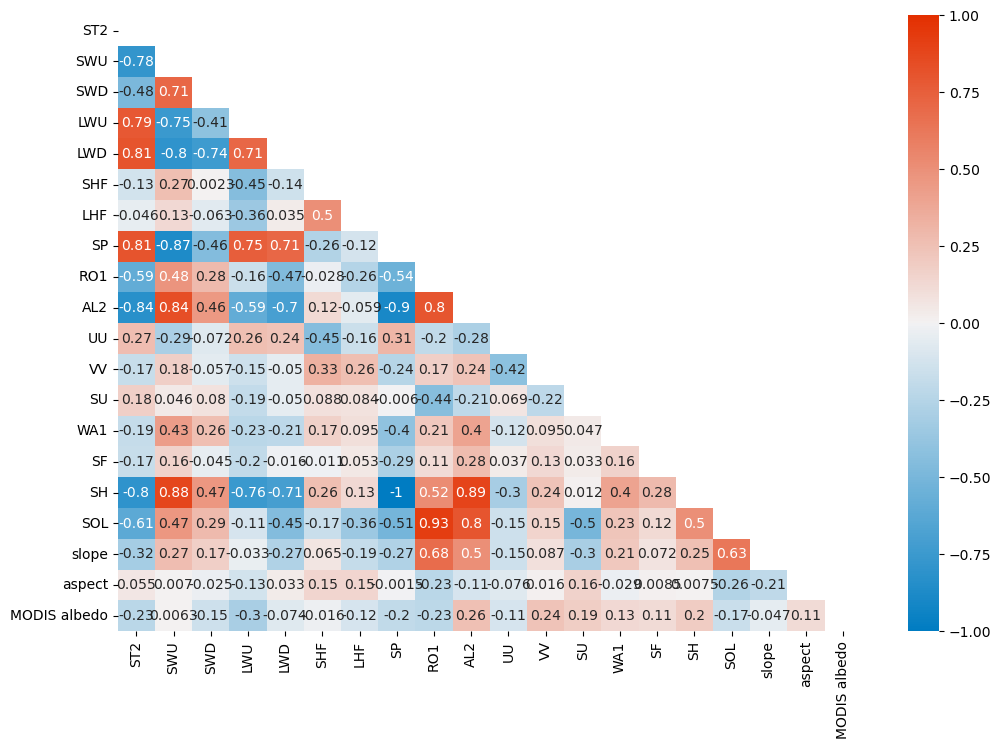

In [29]:
plt.figure(figsize=(12,8))

cmap = sns.diverging_palette(245, 15, s=100, as_cmap=True)
mask = np.triu(np.ones_like(corrmat, dtype=bool))

sns.heatmap(corrmat, annot=True, mask=mask, cmap=cmap, vmin=-1, vmax=1);

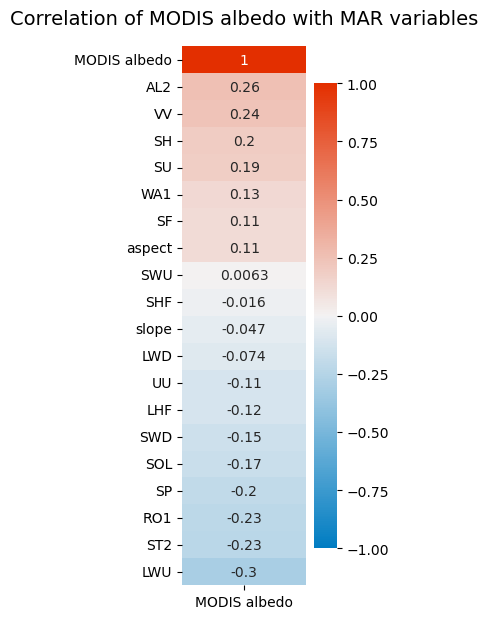

In [30]:
plt.figure(figsize=(2, 7))
heatmap = sns.heatmap(corrmat[['MODIS albedo']].sort_values(by='MODIS albedo', ascending=False), vmin=-1, vmax=1, annot=True, cmap=cmap)
heatmap.set_title('Correlation of MODIS albedo with MAR variables', fontdict={'fontsize':14}, pad=16);

# Prepare data for training and testing

#### Standardize the data so all values are in the 0-range, plusminus a couple (2-5).

In [17]:
# x_dum = np.zeros((x.shape[0], x.shape[1], x.shape[2], x.shape[3]))
# for i in range(x.shape[3]):
    
#     mean, std = np.nanmean(x[:,:,:,i]), np.nanstd(x[:,:,:,i])
        
#     x_dum[:,:,:,i]   = (x[:,:,:,i] - mean)/std

# x = x_dum

In [10]:
# normalize between 0 and 1

x_dum = np.zeros((x.shape[0], x.shape[1], x.shape[2], x.shape[3]))
for i in range(x.shape[3]):
        
    x_dum[:,:,:,i] = (x[:,:,:,i] - np.nanmin(x[:,:,:,i])) / (np.nanmax(x[:,:,:,i]) - np.nanmin(x[:,:,:,i]))

x = x_dum

In [ ]:
# below two cells are to only include albedos > 0.1 but it needs some work with dimensions

In [15]:
# y_masknan = np.where(y > 0.1, 1, np.nan)
# y_mask = y * y_masknan
# x_mask = np.zeros((numberdaystot,207,100,17))
# for i in range(17):
    # x_mask[:,:,:,i] = x[:,:,:,i] * y_masknan[:,:,:]

In [18]:
# y_nonan = y_mask[~np.isnan(y_mask)]
# 
# x_nonan = np.zeros((117412,17))
# 
# for i in range(17):
    # x_mask_dum = x_mask[:,:,:,i]
    # x_nonan[:,i] = x_mask_dum[~np.isnan(x_mask_dum)]

#### Now the data is split into 11 years (training1) and 1 year (testing). Change this once I include more years!
#### dDon't shuffle the data

In [11]:
X_train1, X_test, y_train1, y_test = train_test_split(x, y, test_size=(1/12), shuffle=False)

In [12]:
X_train1.shape, X_test.shape, y_train1.shape, y_test.shape

((1012, 207, 100, 19), (92, 207, 100, 19), (1012, 207, 100), (92, 207, 100))

#### Now the data is further split into 10 years (training) and 1 year (validation). Change this once I include more years!
#### Don't shuffle the data

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=(1/11), shuffle=False)

In [14]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((920, 207, 100, 19), (92, 207, 100, 19), (920, 207, 100), (92, 207, 100))

#### Replace NaNs in output with arbitrary -10's. This is so the custom loss function can ignore these non-bare ice pixels

In [15]:
y_train = np.where(np.isnan(y_train), -10, y_train)
y_val = np.where(np.isnan(y_val), -10, y_val)
y_test = np.where(np.isnan(y_test), -10, y_test)

#### Add dummy dimension of size 1 in dimension number 1 to X_train and X_test. This is so the CNN-LSTM can work with the data

In [16]:
X_train_dum = np.zeros((X_train.shape[0], 1, X_train.shape[1], X_train.shape[2], X_train.shape[3]))
X_train_dum[:,0,:,:,:] = X_train
X_train = X_train_dum

X_val_dum = np.zeros((X_val.shape[0], 1, X_val.shape[1], X_val.shape[2], X_val.shape[3]))
X_val_dum[:,0,:,:,:] = X_val
X_val = X_val_dum

X_test_dum = np.zeros((X_test.shape[0], 1, X_test.shape[1], X_test.shape[2], X_test.shape[3]))
X_test_dum[:,0,:,:,:] = X_test
X_test = X_test_dum

In [17]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((920, 1, 207, 100, 19),
 (920, 207, 100),
 (92, 1, 207, 100, 19),
 (92, 207, 100),
 (92, 1, 207, 100, 19),
 (92, 207, 100))

# Initialize and run CNN-LSTM model

#### Define custom loss function. This is a regular mean squared error (MSE) loss function. But it will only return a value when the predictant (MODIS albedo) is higher than -9, so the CNN-LSTM will only train on the bare ice pixels and ignore the other pixels

In [18]:
def my_loss_fn(y_true, y_pred):
    
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    
    y_true_mask = tf.cast(tf.where(y_true > -9, 1, 0), dtype=tf.float32)
    # y_true_mask = tf.cast(tf.where(y_true > 0, 1, 0), dtype=tf.float32)

    squared_difference = tf.multiply(tf.square(y_true - y_pred), y_true_mask) / tf.math.reduce_sum(y_true_mask)
    
    # return tf.reduce_mean(squared_difference, axis=-1)
    return squared_difference                              # try witout reduce mean

In [495]:
# # add physical constraint that y_pred has to be above 0.05

# def my_loss_fn(y_true, y_pred):
    
#     y_true = tf.cast(y_true, dtype=tf.float32)
#     y_pred = tf.cast(y_pred, dtype=tf.float32)
    
#     y_true_mask = tf.cast(tf.where(y_true > -9, 1, 0), dtype=tf.float32)
    
#     y_pred_mask = tf.cast(tf.where(y_pred > 0.05, 1, 0), dtype=tf.float32)
    
#     y_true_pred_mask = y_true_mask * y_pred_mask
    
#     squared_difference = tf.multiply(tf.square(y_true - y_pred), y_true_mask) / tf.math.reduce_sum(y_true_mask)
#     squared_difference = tf.math.reduce_sum(tf.square(tf.multiply(y_true, y_true_mask) - tf.multiply(y_pred, y_pred_mask))) / tf.math.reduce_sum(y_true_pred_mask)
    
#     return tf.reduce_mean(squared_difference, axis=-1)
#     # return squared_difference

# Hyperparameter tuning with Sherpa

In [ ]:
multiprocessing.set_start_method("fork")

In [192]:
parameters = [sherpa.Ordinal('learning_rate', range=[0.01, 0.1, 1]), #10, 1000]
              sherpa.Ordinal('dropout_rate', range=[0.25, 0.5, 0.75]),
              sherpa.Ordinal('kernel_size', range=[3, 5, 7]),
              sherpa.Ordinal('batch_size', range=[8, 16, 32]),
              sherpa.Ordinal('n_lstm_unit1', range=[10, 30, 50]),
              sherpa.Ordinal('n_lstm_unit2', range=[5, 10, 15]),
              sherpa.Ordinal('n_filters', range=[10, 30, 50]),
              sherpa.Ordinal('pool_size', range=[2, 4, 8]),
              sherpa.Choice(name='activation', range=['relu'])
              sherpa.Choice(name='metric', range=['accuracy', 'val_loss', 'mean_squared_error'])]

alg = sherpa.algorithms.RandomSearch(max_num_trials=10000)

In [ ]:
study = sherpa.Study(parameters=parameters,
                     algorithm=alg,
                     lower_is_better=True)

In [ ]:
for trial in study:
    
    model = Sequential()
    
    model.add(Dropout(trial.parameters['dropout_rate']))

    model.add(Input(shape=(1, n_lat, n_lon, n_feature)))

    model.add(TimeDistributed(Conv2D(trial.parameters['n_filters'],
                                     (trial.parameters['kernel_size'], trial.parameters['kernel_size']), 
                                     padding='same',
                                     activation=trial.parameters['activation']),
                              input_shape=(1, n_lat, n_lon, n_feature)))

    model.add(TimeDistributed(AveragePooling2D(trial.parameters['pool_size'])))
    model.add(TimeDistributed(GlobalAveragePooling2D()))

    model.add(LSTM(trial.parameters['n_lstm_unit1'], activation=trial.parameters['activation'], return_sequences=True))
    model.add(LSTM(trial.parameters['n_lstm_unit2'], activation=trial.parameters['activation']))
    
    model.add(Dense(n_lat*n_lon))
    model.add(Activation('linear'))
    model.add(Reshape((n_lat, n_lon)))

    model.compile(loss=my_loss_fn,
                  optimizer=tf.keras.optimizers.Adam(learning_rate=trial.parameters['learning_rate']),
                  metrics=['accuracy'])
        
    model.fit(X_train, y_train,
              epochs=20,
              batch_size=trial.parameters['batch_size'],
              verbose=1,
              validation_data=(X_val, y_val),
              callbacks=[study.keras_callback(trial, objective_name='val_loss')])
              # callbacks=[study.keras_callback(trial, objective_name=trial.parameters['metric'])])
    
    study.finalize(trial)

In [ ]:
study.get_best_result()

# Set hyperparameters for CNN-LSTM

In [19]:
n_filters      = 150 #250 # number of filters
kernel_size    = 5 #3  # kernel size for convolutional layers
pool_size      = 16  # size for average pooling layers
n_lstm_unit1   = 50 #25 # number of LSTM units
n_lstm_unit2   = 25 # number of LSTM units
drop_out       = 0.25

activation     = 'relu' # activation function
learning_rate  = 1  #0.1  # learning rate
minibatch_size = 32 #32   # batch size
num_epochs     = 150 #50   # number of total epochs

In [20]:
# The number of data points I use is 22y*92d*207lat*100lon*19feature = ~800,000,000
# The number of trainable parameters should be about 10-30 less than the number of data points
# So, about 27,000,000-80,000,000 of trainable parameters

# Set up CNN-LSTM model

In [21]:
model = Sequential()

model.add(Input(shape=(1, n_lat, n_lon, n_feature)))

model.add(TimeDistributed(Conv2D(n_filters, (kernel_size, kernel_size), 
                                     padding='same', activation=activation), input_shape=(1, n_lat, n_lon, n_feature)))
model.add(TimeDistributed(Conv2D(n_filters, (kernel_size, kernel_size), 
                                     padding='same', activation=activation), input_shape=(1, n_lat, n_lon, n_feature)))

model.add(TimeDistributed(AveragePooling2D(pool_size)))
model.add(TimeDistributed(GlobalAveragePooling2D()))

model.add(LSTM(n_lstm_unit1, activation=activation, return_sequences=True))
model.add(Dense(n_lat*n_lon)) # add dense between lstm's or cnn's ? or multiple in a raw to increase number of params.
model.add(LSTM(n_lstm_unit2, activation=activation)) # try without

model.add(Activation('linear'))
model.add(Dense(n_lat*n_lon)) # add dense between lstm's or cnn's ? or multiple in a raw to increase number of params.

model.add(Dropout(drop_out)) # play around with location

model.add(Reshape((n_lat, n_lon)))

model.compile(loss=my_loss_fn, optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)) #, metrics=['val_loss'])
# model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=[tf.keras.metrics.MeanSquaredError()])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 1, 207, 100, 150)  71400    
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 1, 12, 6, 150)    0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 1, 150)           0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 1, 50)             40200     
                                                                 
 lstm_1 (LSTM)               (None, 25)                7600      
                                                        

#### Fit CNN-LSTM model

In [22]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train, y_train, 
                    batch_size = minibatch_size,
                    epochs = num_epochs,
                    verbose=1,
                    callbacks=[early_stop],
                    validation_data =(X_val, y_val))

Epoch 1/150
29/29 [==============================] - 18s 543ms/step - loss: 2.7413e-07 - val_loss: 2.1136e-07
Epoch 2/150
29/29 [==============================] - 15s 526ms/step - loss: 2.1794e-07 - val_loss: 1.5053e-07
Epoch 3/150
29/29 [==============================] - 15s 523ms/step - loss: 1.7125e-07 - val_loss: 1.0732e-07
Epoch 4/150
29/29 [==============================] - 15s 519ms/step - loss: 1.4087e-07 - val_loss: 8.1105e-08
Epoch 5/150
29/29 [==============================] - 15s 523ms/step - loss: 1.2329e-07 - val_loss: 6.5191e-08
Epoch 6/150
29/29 [==============================] - 15s 523ms/step - loss: 1.1264e-07 - val_loss: 5.4967e-08
Epoch 7/150
29/29 [==============================] - 15s 519ms/step - loss: 1.0463e-07 - val_loss: 4.8256e-08
Epoch 8/150
29/29 [==============================] - 15s 518ms/step - loss: 9.9844e-08 - val_loss: 4.3057e-08
Epoch 9/150
29/29 [==============================] - 15s 518ms/step - loss: 9.6642e-08 - val_loss: 3.7325e-08
Epoch 10/1

#### Summarize history for loss

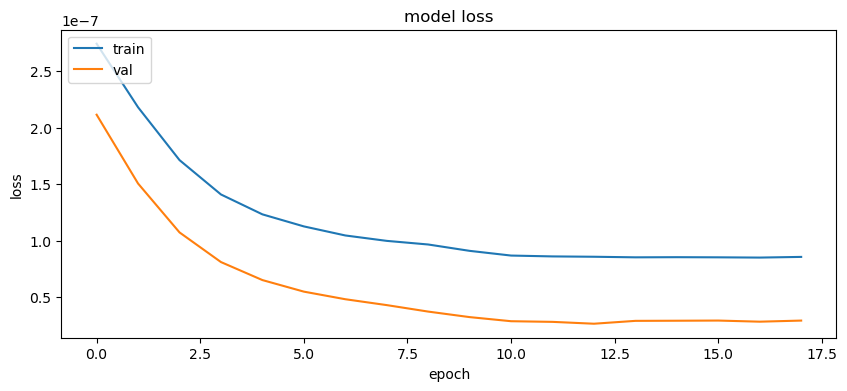

In [23]:
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Calculate CNN-LSTM albedo predictions

In [25]:
y_test_pred = model.predict(X_test)
y_test_pred = y_test_pred.reshape(y_test_pred.shape[0], X_train.shape[2], X_train.shape[3])

3/3 [==============================] - 1s 161ms/step


#### Turn non-bare ice pixels from -10's back into NaNs. This is for visualization

In [53]:
y_test_pred = np.where(y_test == -10, np.nan, y_test_pred)
y_test = np.where(y_test == -10, np.nan, y_test)


In [54]:
np.nanmean(y_test), np.nanmean(y_test_pred)

(0.4103077460222456, 0.30637246)

# Visualization

#### Map plots of observed ice albedo (left), predicted ice albedo (middle), and their difference (right)

/tmp/ipykernel_944/1718864489.py:7: RuntimeWarning: Mean of empty slice
  p1 = ax1.pcolor(LON[:n_lat,:n_lon], LAT[:n_lat,:n_lon], np.nanmean(y_test, 0), cmap=cmap, zorder=2, vmin=0.1, vmax=0.8)
/tmp/ipykernel_944/1718864489.py:7: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  p1 = ax1.pcolor(LON[:n_lat,:n_lon], LAT[:n_lat,:n_lon], np.nanmean(y_test, 0), cmap=cmap, zorder=2, vmin=0.1, vmax=0.8)
/tmp/ipykernel_944/1718864489.py:20: RuntimeWarning: Mean of empty slice
  p2 = ax2.pcolor(LON[:n_lat,:n_lon], LAT[:n_lat,:n_lon], np.nanmean(y_test_pred, 0), cmap=cmap, zorder=2, vmin=0.1, vmax=0.8)
/tmp/ipykernel_944/1718864489.py:20: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated

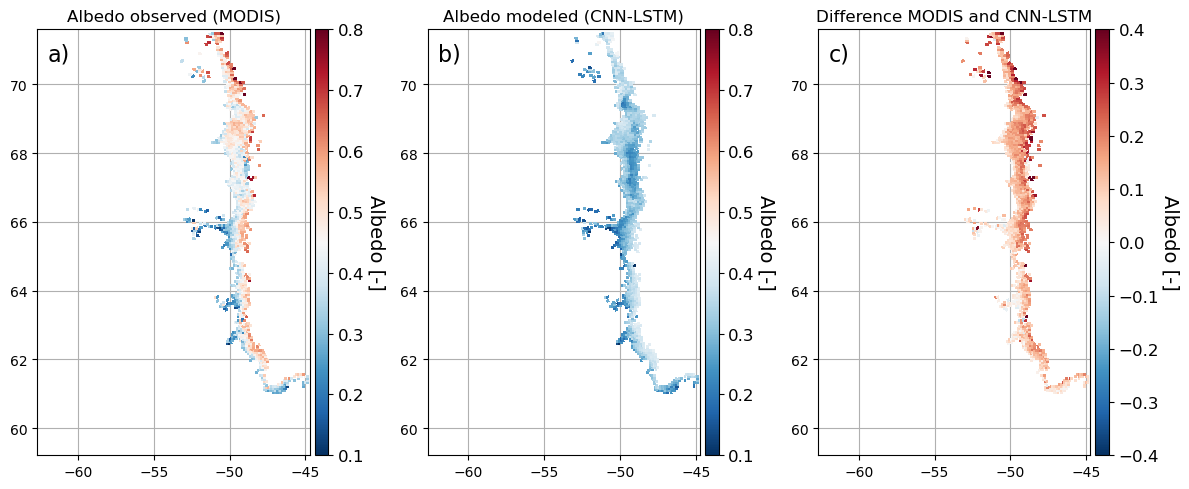

In [57]:
fig = plt.figure(figsize=(12, 5))

cmap = 'RdBu_r'

ax1 = fig.add_subplot(131)
# p1 = ax1.pcolor(ds2020.LON.values[:n_lat,:n_lon], ds2020.LAT.values[:n_lat,:n_lon], np.nanmean(y_test, 0), cmap=cmap, zorder=2, vmin=0.1, vmax=0.8)
p1 = ax1.pcolor(LON[:n_lat,:n_lon], LAT[:n_lat,:n_lon], np.nanmean(y_test, 0), cmap=cmap, zorder=2, vmin=0.1, vmax=0.8)
ax1.text(-62, 70.7, 'a)', fontsize=16)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar1 = fig.colorbar(p1, cax=cax, orientation='vertical')
cbar1.set_label('Albedo [-]', rotation=270, fontsize=14)
cbar1.ax.tick_params(labelsize=12)
cbar1.ax.get_yaxis().labelpad = 15
ax1.grid(zorder=1)
ax1.set_title('Albedo observed (MODIS)')

ax2 = fig.add_subplot(132)
# p2 = ax2.pcolor(ds2020.LON.values[:n_lat,:n_lon], ds2020.LAT.values[:n_lat,:n_lon], np.nanmean(y_test_pred, 0), cmap=cmap, zorder=2, vmin=0.1, vmax=0.8)
p2 = ax2.pcolor(LON[:n_lat,:n_lon], LAT[:n_lat,:n_lon], np.nanmean(y_test_pred, 0), cmap=cmap, zorder=2, vmin=0.1, vmax=0.8)
ax2.text(-62, 70.7, 'b)', fontsize=16)
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar2 = fig.colorbar(p2, cax=cax, orientation='vertical')
cbar2.set_label('Albedo [-]', rotation=270, fontsize=14)
cbar2.ax.tick_params(labelsize=12)
cbar2.ax.get_yaxis().labelpad = 15
ax2.grid(zorder=1)
ax2.set_title('Albedo modeled (CNN-LSTM)')

ax3 = fig.add_subplot(133)
p3 = ax3.pcolor(LON[:n_lat,:n_lon], LAT[:n_lat,:n_lon], np.nanmean(y_test, 0) - np.nanmean(y_test_pred, 0), cmap=cmap, zorder=2, vmin=-0.4 ,vmax=0.4)
ax3.text(-62, 70.7, 'c)', fontsize=16)
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar3 = fig.colorbar(p3, cax=cax, orientation='vertical')
cbar3.set_label('Albedo [-]', rotation=270, fontsize=14)
cbar3.ax.tick_params(labelsize=12)
cbar3.ax.get_yaxis().labelpad = 15
ax3.grid(zorder=1)
ax3.set_title('Difference MODIS and CNN-LSTM')

plt.tight_layout()

#### MSE of MODIS and CNN-LSTM albedo

In [58]:
MSE1 = (np.nansum((np.nanmean(y_test, 0) - np.nanmean(y_test_pred, 0))**2)) / np.sum(~np.isnan(np.nanmean(y_test, 0)))
MSE1

/tmp/ipykernel_944/1480134688.py:1: RuntimeWarning: Mean of empty slice
  MSE1 = (np.nansum((np.nanmean(y_test, 0) - np.nanmean(y_test_pred, 0))**2)) / np.sum(~np.isnan(np.nanmean(y_test, 0)))


0.022452755097538836

In [59]:
# AL2_2019 = ds2019.AL2.values[jun1:aug31+1,0,:n_lat,:n_lon] * np.where(y_test[:92,:n_lat,:n_lon] > -8, 1, np.nan)
# AL2_2020 = ds2020.AL2.values[jun1_leap:aug31_leap+1,0,:n_lat,:n_lon] * np.where(y_test[:,:n_lat,:n_lon] > -8, 1, np.nan)

In [60]:
# AL2_1920 = np.zeros((184, 207, 100))
# AL2_1920[:92,:,:] = AL2_2019
# AL2_1920[92:,:,:] = AL2_2020

#### MSE of MODIS and MAR albedo

In [61]:
MSE2 = (np.nansum((np.nanmean(y_test, 0) - (np.nanmean(AL2_2020, 0) * np.where(np.nanmean(y_test[:,:n_lat,:n_lon], 0) > -8, 1, np.nan)))**2)) / np.sum(~np.isnan(np.nanmean(y_test, 0)))
MSE2

/tmp/ipykernel_944/1330590354.py:1: RuntimeWarning: Mean of empty slice
  MSE2 = (np.nansum((np.nanmean(y_test, 0) - (np.nanmean(AL2_2020, 0) * np.where(np.nanmean(y_test[:,:n_lat,:n_lon], 0) > -8, 1, np.nan)))**2)) / np.sum(~np.isnan(np.nanmean(y_test, 0)))


0.027764462712781553

## Scatterplot of MODIS and CNN-LSTM albedo --> for just albedo

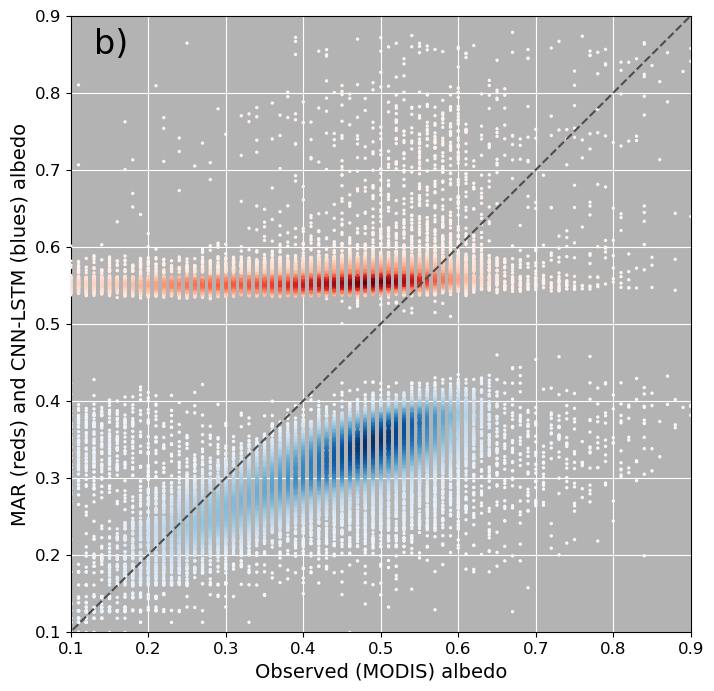

In [62]:
fig = plt.figure(figsize=(8,8))
ax = plt.gca()

select = ~np.isnan(y_test)
select_pred = ~np.isnan(y_test_pred)
select_AL2 = ~np.isnan(AL2_2020)
y_test_plot = y_test[select]
y_test_pred_plot = y_test_pred[select_pred]
AL2_plot = AL2_2020[select_AL2]


# Calculate the point density
xy1 = np.vstack([y_test_plot, y_test_pred_plot])
z1 = gaussian_kde(xy1)(xy1)
xy2 = np.vstack([y_test_plot, AL2_plot])
z2 = gaussian_kde(xy2)(xy2)

plt.plot(np.arange(-1,1,0.1), np.arange(-1,1,0.1), color=[0.3, 0.3, 0.3], linestyle='--', linewidth=1.5, zorder=4)
plt.scatter(y_test_plot, y_test_pred_plot, c=z1, s=2, zorder=2, cmap='Blues')
plt.scatter(y_test_plot, AL2_plot, c=z2, s=2, zorder=3, cmap='Reds')
ax.text(0.13, 0.85, 'b)', fontsize=24)

plt.xlabel('Observed (MODIS) albedo', fontsize=14)
plt.ylabel('MAR (reds) and CNN-LSTM (blues) albedo', fontsize=14)
plt.grid(color='w', zorder=1)
ax.set_facecolor([0.7, 0.7, 0.7])
plt.tick_params(labelsize=12)
plt.xlim(0.1, 0.9);
plt.ylim(0.1, 0.9);

## Scatterplot of MODIS and CNN-LSTM albedo --> for difference in albedo between model and observation

#### R^2 between observed and predicted (CNN-LSTM) ice albedo

In [63]:
y_test_flat = y_test.flatten()
select = np.where(~np.isnan(y_test_flat))
y_test_nonnan = y_test_flat[select]

y_test_pred_flat = y_test_pred.flatten()
select_pred = np.where(~np.isnan(y_test_pred_flat))
y_test_pred_nonnan = y_test_pred_flat[select]

In [64]:
slope, intercept, r_value, p_value, std_err = stats.linregress(y_test_nonnan, y_test_pred_nonnan)
slope, intercept, r_value, p_value, std_err

In [66]:
R2 = r_value**2
R2

0.29857146423448616

#### R^2 between observed and predicted (MAR) ice albedo

In [175]:
R2_2 = ma.corrcoef(ma.masked_invalid(y_test.flatten()), ma.masked_invalid(AL2_2020.flatten()))[1,0]**2
R2_2

0.07169590698279893

#### Time series of average albedo throughout 2020

/tmp/ipykernel_944/1689337231.py:2: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(np.nanmean(y_test, 2), 1), label='y test')
/tmp/ipykernel_944/1689337231.py:3: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(np.nanmean(y_test_pred, 2), 1), label='y test predicted')


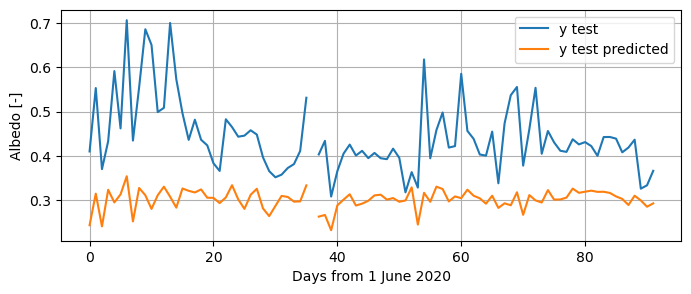

In [67]:
plt.figure(figsize=(8,3))
plt.plot(np.nanmean(np.nanmean(y_test, 2), 1), label='y test')
plt.plot(np.nanmean(np.nanmean(y_test_pred, 2), 1), label='y test predicted')
plt.xlabel('Days from 1 June 2020')
plt.ylabel('Albedo [-]')
plt.legend()
plt.grid()

#### Calculation and map plot of average R^2 per pixel in the study domain

In [45]:
corrmap = np.zeros((n_lat, n_lon))
for i in range(n_lat):
    for j in range(n_lon):
        corrmap[i,j] = ma.corrcoef(ma.masked_invalid(y_test[:,i,j]), ma.masked_invalid(y_test_pred[:,i,j]))[1,0]

corrmap = corrmap**2

/tmp/ipykernel_942/835562255.py:4: UserWarning: Warning: converting a masked element to nan.
  corrmap[i,j] = ma.corrcoef(ma.masked_invalid(y_test[:,i,j]), ma.masked_invalid(y_test_pred[:,i,j]))[1,0]


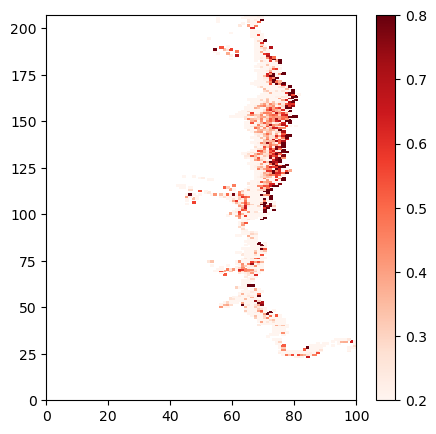

In [48]:
plt.figure(figsize=(5,5))
plt.pcolor(corrmap, cmap='Reds', vmin=0.2, vmax=0.8)
plt.colorbar()

# Shapley

In [ ]:
explainer = shap.DeepExplainer(model, X_train[700:710,:,:,:,:].flatten())
shap_values = explainer(X_test)